<a href="https://colab.research.google.com/github/cmansoo/funko-pop-cnn/blob/main/MansooNet_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook, we will use SMOTE to oversample imbalanced data. We will also build models for each classes of data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D, BatchNormalization, Conv2D, Dropout, Activation, Dense, Flatten, AveragePooling2D, InputLayer, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.optimizers import SGD
from imblearn.over_sampling import SMOTE
from itertools import product
from keras.metrics import Recall
from keras.utils import plot_model
from keras.models import load_model

In [ ]:
# mount drive
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/SEIS 764/project")
!ls

Mounted at /content/drive
'764 final project images'		        image_gen.ipynb
 classfiers.ipynb			       'MansooNet - gender and initial training.ipynb'
 Copy_of_764project_gender_optimization.ipynb   MansooNet.h5
 data					       'MansooNet - SMOTE.ipynb'
 funko_file_map.csv			        model.png
 gender_after_smote_cnn2flatten.h5	       'SEIS764 project.ipynb'
 gender_after_smote_flatten2dense.h5	        test.csv
 gender_before_smote.h5			        test.gsheet
 gender_final.h5			       'Untitled document.gdoc'
'grid search example using a loop.ipynb'


## Define Functions

In [ ]:
# image preprocessing
def img_preprocess(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    y_name: str,
    target_size: tuple[int, int],
    batch_size: int,
    class_mode: str
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

  train_datagen = ImageDataGenerator(
      rescale=1./255.,
      validation_split=0.2,
      shear_range=0.2,
      zoom_range=0.2, #augmentation params, experiment later
      vertical_flip=True
  )

  test_datagen = ImageDataGenerator(rescale=1./255.)

  train_data = train_datagen.flow_from_dataframe(
      dataframe=df_train,
      x_col="Image Path",
      y_col=y_name,
      target_size=target_size,
      batch_size=batch_size,
      class_mode=class_mode,
      shuffle=False,
      subset="training"
  )

  val_data = train_datagen.flow_from_dataframe(
      dataframe=df_train,
      x_col="Image Path",
      y_col=y_name,
      target_size=target_size,
      batch_size=batch_size,
      class_mode=class_mode,
      shuffle=False,
      subset="validation"
  )

  test_data = test_datagen.flow_from_dataframe(
      dataframe=df_test,
      x_col="Image Path",
      y_col=y_name,
      target_size=target_size,
      batch_size=1,
      class_mode=class_mode,
      shuffle=False
  )

  return (train_data, val_data, test_data)

# create model
#------------------------ new structure ---------------------------
# still needs some experiment, requires longer epochs
def create_full_model(
    target_size: tuple[int, int],
    num_class: int
):
  model = Sequential()

  # conv 1
  model.add(InputLayer(input_shape = target_size + (num_class,)))
  model.add(Conv2D(filters=72, kernel_size=(11,11), strides=3, padding="valid"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding="valid"))
  # model.add(AveragePooling2D(pool_size=(3,3)))

  # conv 2
  model.add(Conv2D(filters=144, kernel_size=(7,7), padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(3,3)))

  # conv 3
  model.add(Conv2D(filters=216, kernel_size=(5,5), padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  # model.add(MaxPooling2D(pool_size=(2,2)))

  # conv 4
  model.add(Conv2D(filters=360, kernel_size=(3,3), padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # flatten
  model.add(Flatten(name="flatten_1"))

  # dense
  model.add(Dense(units=4200, activation="relu"))
  model.add(Dropout(0.4))
  model.add(Dense(units=1500, activation="relu"))
  model.add(Dropout(0.4))
  model.add(Dense(units=600, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(units=250, activation="relu"))
  model.add(Dense(units=100, activation="relu"))
  model.add(Dense(units=50, activation="relu"))
  model.add(Dense(units=20, activation="relu"))
  model.add(Dense(units=8, activation="relu"))
  model.add(Dense(units=num_class, activation="softmax"))

  return model

#-----------------------------------------------------------------------

# plot model history
def plot_history(history):
  plt.plot(history.history["accuracy"])
  plt.plot(history.history["val_accuracy"])
  plt.legend(labels=["Accuracy", "Validation Accuracy"])
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Training History")
  plt.show()

# evaluate the model and report
# option to choose which data to evaluate on
def make_eval_reports(model, train_dat, test_dat, vm=20, eval_opt="test"):
  # reset
  train_dat.reset()
  test_dat.reset()

  if eval_opt == "test":
    pred_scores = model.predict(test_dat, verbose=True)
    pred_labels = pred_scores.argmax(axis=1)
    true_labels = test_dat.labels
  elif eval_opt == "train":
    pred_score = model.predict(train_dat, verbose=True)
    pred_labels = pred_scores.argmax(axis=1)
    true_labels = train_dat.labels
  else:
    raise Exception("invalid parameter for `eval_opt`. Choose from 'test' or 'train'.")

  print("predicted labels: \n", pred_labels)
  print("\n {} data labels:\n".format(eval_opt), true_labels)

  accuracy = accuracy_score(true_labels, pred_labels)
  cm = confusion_matrix(true_labels, pred_labels)
  cr = classification_report(true_labels, pred_labels)

  # report metrics
  print("\n {0} data accuracy score: {1:.2f}".format(eval_opt, accuracy))
  print("\n confusion matrix: \n", cm)
  print("\n classification report", cr)

  # plot confusion matrix
  cm_plot = sns.heatmap(cm, linewidths=1, vmax=vm, square=True, cmap="Blues", annot=True)
  plt.title("{} data confusion matrix".format(eval_opt))
  plt.show()

  # roc and auc
  onehot_test_label = pd.get_dummies(test_dat.labels).to_numpy()
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_class):
    fpr[i], tpr[i], _ = roc_curve(onehot_test_label[:,i], pred_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"class {i}")

  plt.xlabel('\nFalse Positive Rate')
  plt.ylabel('\nTrue Positive Rate')
  plt.title("\nROC curve")
  plt.legend()
  plt.show()
  print("\nAUC: ", roc_auc)



  return accuracy, cm, cr, cm_plot

# # extract z-code up to flatten layer
# def z_code_flatten(full_model, train_dat):
#   upto_flatten = Model(inputs=full_model.input, outputs=full_model.get_layer("flatten_1").output)
#   z_code = upto_flatten.predict(train_dat)
#   z_labels = np.array(train_dat.labels)

#   return upto_flatten, z_code, z_labels

# oversample the flatten layer using SMOTE
def my_smote(z, z_lab, nn=5):
  """
  z: extracted z-code (cnn 2 flatten) to oversample
  z_lab: train_labels or test labels
  nn: number of neighbors for SMOTE
  """
  z_lab = np.array(z_lab)
  sampler = SMOTE(k_neighbors=nn, random_state=123)
  z_oversampled, z_oversampled_y = sampler.fit_resample(z, z_lab)
  z_oversampled_y_cat = pd.get_dummies(z_oversampled_y).to_numpy()

  return z_oversampled, z_oversampled_y, z_oversampled_y_cat

##### visualize label counts
def plot_label_counts(z_labels, opt):
  """
  z_labels: np.array (or list might work?) of train labels
  opt: option for title - 'before' or 'after' oversampling
  """
  unique, counts = np.unique(z_labels, return_counts=True)
  counter = dict(zip(unique, counts))
  # print counts
  for lab, ct in counter.items():
    print("class {}: n = {}".format(lab, ct))
  # plot
  plt.bar(counter.keys(), counter.values())
  plt.title("counts {} oversampling".format(opt))
  plt.show()



#### create a model for dense layer only
def create_flatten2dense(n_class):
  # build the second part
  model = Sequential()

  # dense
  model.add(Dense(units=4200, activation="relu", input_shape=(9000,)))
  model.add(Dropout(0.4))
  model.add(Dense(units=1500, activation="relu"))
  model.add(Dropout(0.4))
  model.add(Dense(units=600, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(units=250, activation="relu"))
  model.add(Dense(units=100, activation="relu"))
  model.add(Dense(units=50, activation="relu"))
  model.add(Dense(units=20, activation="relu"))
  model.add(Dense(units=8, activation="relu"))
  model.add(Dense(units=n_class, activation="softmax"))

  return model

## Read Data and split


In [ ]:
funko_df = pd.read_csv("funko_file_map.csv")
# remove unnecessary paths
funko_df["Image Path"] = funko_df["Image Path"].str.replace("drive/MyDrive/SEIS764/", "")

# change boolean columns to strings
for col in funko_df.columns.drop(["Image Path", "Gender", "Name"]):
  funko_df[col] = np.where(funko_df[col], "y", "n")

# split
train_df, test_df = train_test_split(funko_df, test_size=0.2, random_state=100)
print("train dataset", train_df.shape)
display(train_df)
print("test dataset", test_df.shape)
display(test_df)

train dataset (212, 9)


,Image Path,Human,Gender,Facial Hair,Glasses,Hat,Item in hand,Sunny,Name
180,764 final project images/Towelie6.jpeg,n,m,n,n,n,n,n,Towelie
260,764 final project images/SteamBoatWilly4.jpeg,n,o,n,n,y,n,n,SteamBoatWilly
201,764 final project images/CokeBear7.jpeg,n,o,n,n,n,y,n,CokeBear
171,764 final project images/WildThing4.jpeg,n,o,y,n,n,n,n,WildThing
230,764 final project images/Max6.jpeg,n,o,n,n,n,n,n,Max
...,...,...,...,...,...,...,...,...,...
226,764 final project images/Max2.jpeg,n,o,n,n,n,n,n,Max
66,764 final project images/Gohan2.jpeg,y,m,n,n,y,n,n,Gohan
53,764 final project images/Grommit6.jpeg,n,o,n,n,n,n,n,Grommit
79,764 final project images/Vegeta8.jpeg,y,m,n,n,n,n,n,Vegeta


test dataset (53, 9)


,Image Path,Human,Gender,Facial Hair,Glasses,Hat,Item in hand,Sunny,Name
243,764 final project images/MrPB5.jpeg,n,o,n,n,y,y,n,MrPB
160,764 final project images/Tony.jpeg,y,m,n,n,n,y,n,Tony
257,764 final project images/Micky6.jpeg,n,o,n,n,y,n,n,Micky
256,764 final project images/SteamBoatWilly.jpeg,n,o,n,n,y,n,n,SteamBoatWilly
110,764 final project images/PickleRick3.jpeg,n,o,n,n,n,y,n,PickleRick
236,764 final project images/Rick.jpeg,y,m,n,n,n,y,n,Rick
52,764 final project images/Grommit4.jpeg,n,o,n,n,n,n,n,Grommit
263,764 final project images/SteamBoatWilly8.jpeg,n,o,n,n,y,n,n,SteamBoatWilly
97,764 final project images/Gimli5.jpeg,y,m,y,n,y,y,n,Gimli
245,764 final project images/MrPB4.jpeg,n,o,n,n,y,y,n,MrPB


## Load MansooNet
### 1. Gender
Oversample using SMOTE

Then train the model

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 72)        26208     
                                                                 
 batch_normalization_16 (Ba  (None, 72, 72, 72)        288       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 72, 72, 72)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 35, 35, 72)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 35, 35, 144)       508

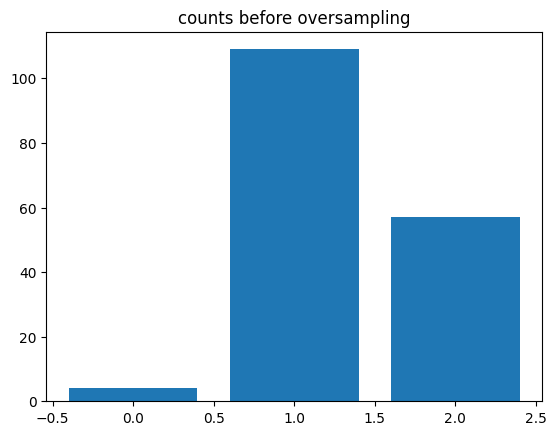

class 0: n = 109
class 1: n = 109
class 2: n = 109


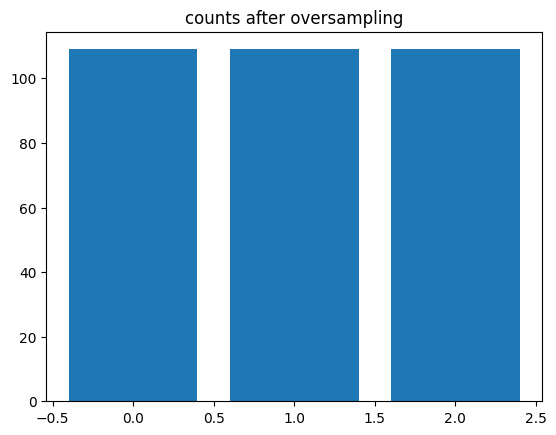

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 4200)              37804200  
                                                                 
 dropout_21 (Dropout)        (None, 4200)              0         
                                                                 
 dense_64 (Dense)            (None, 1500)              6301500   
                                                                 
 dropout_22 (Dropout)        (None, 1500)              0         
                                                                 
 dense_65 (Dense)            (None, 600)               900600    
                                                                 
 dropout_23 (Dropout)        (None, 600)               0         
                                                                 
 dense_66 (Dense)            (None, 250)              

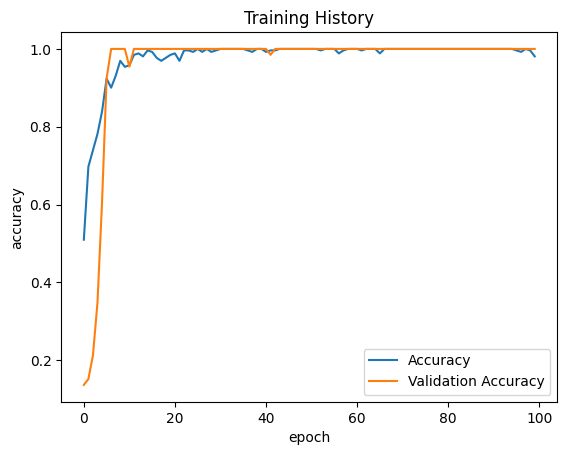

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_40 (Functional)       (None, 9000)              2015568   
                                                                 
 sequential_7 (Sequential)   (None, 3)                 45187915  
                                                                 
Total params: 47203483 (180.07 MB)
Trainable params: 47201899 (180.06 MB)
Non-trainable params: 1584 (6.19 KB)
_________________________________________________________________
7/7 [==============================] - 6s 833ms/step
predicted labels: 
 [2 1 2 2 2 1 2 1 1 2 1 2 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 2 0 1 2 1 2 2 1 0 2 1 2 1 1 1 1]

 test data labels:
 [2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1]

 test data accuracy score: 0.87

 confusi

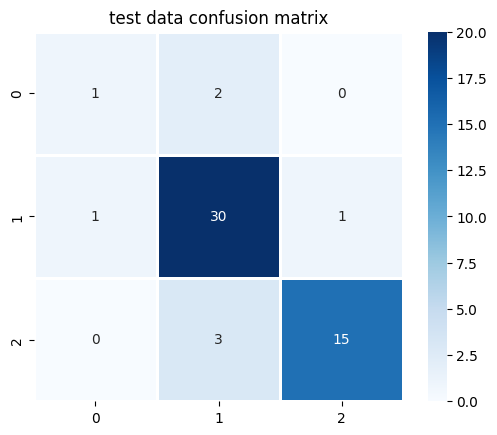

NameError: ignored

In [ ]:
# parameters
target_size = (224, 224)
epoch = 100
batch_size = 8
n_class = 3

# load model
MansooNet = load_model("MansooNet.h5")
# MansooNet = load_model("gender_before_smote.h5")

# extract layers up to flatten
upto_flatten = Model(inputs=MansooNet.input, outputs=MansooNet.get_layer("flatten_1").output)
upto_flatten.summary()


# generate image data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# generate data
train_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Path",
    y_col="Gender",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    subset="training"
)

val_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Path",
    y_col="Gender",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
)

# separate generator for test dataset
test_datagen = ImageDataGenerator(rescale=1./255.)

test_data = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image Path",
    y_col="Gender",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# extract z code
z_code_train = upto_flatten.predict(train_data)
z_code_test = upto_flatten.predict(test_data)


# plot class labels
plot_label_counts(train_data.labels, "before")

# SMOTE
oversampled_x, oversampled_y, oversampled_y_cat = my_smote(z_code_train, train_data.labels, nn=3)

# visaulize result after smote
plot_label_counts(oversampled_y, "after")


# train the model
# create dense layers
new_dense = create_flatten2dense(n_class)
new_dense.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=["accuracy"])
new_dense.summary()

# fit
# record start time
start_time = time.time()
history = new_dense.fit(oversampled_x, oversampled_y_cat, epochs=epoch, batch_size=batch_size, verbose=True, validation_split=0.2)
# record endtime
end_time = time.time()

print(f"\nTraining with Epochs={epoch}, Batch Size={batch_size}")
training_time = (end_time - start_time)/60
print(f'Model Training + Validation Time: {training_time:.2f} minutes')

# plot history
plot_history(history)

# print eval report
# piece the model together and print eval report
full_model = Sequential([upto_flatten, new_dense])
full_model.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=["accuracy"])
full_model.summary()
accuracy, cm, cr, _ = make_eval_reports(full_model, train_data, test_data, 20, eval_opt="test")

7/7 [==============================] - 6s 818ms/step
predicted labels: 
 [2 1 2 2 2 1 2 1 1 2 1 2 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 2 0 1 2 1 2 2 1 0 2 1 2 1 1 1 1]

 test data labels:
 [2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1]

 test data accuracy score: 0.87

 confusion matrix: 
 [[ 1  2  0]
 [ 1 30  1]
 [ 0  3 15]]

 classification report               precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.86      0.94      0.90        32
           2       0.94      0.83      0.88        18

    accuracy                           0.87        53
   macro avg       0.76      0.70      0.73        53
weighted avg       0.86      0.87      0.86        53



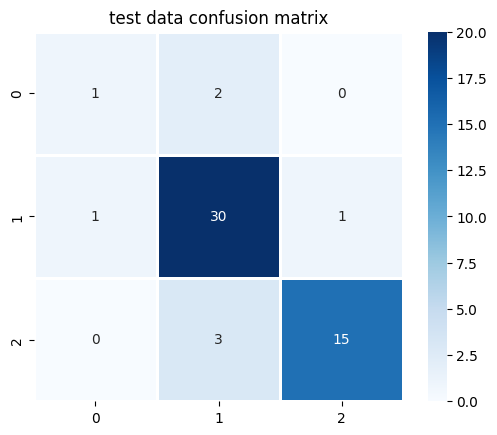

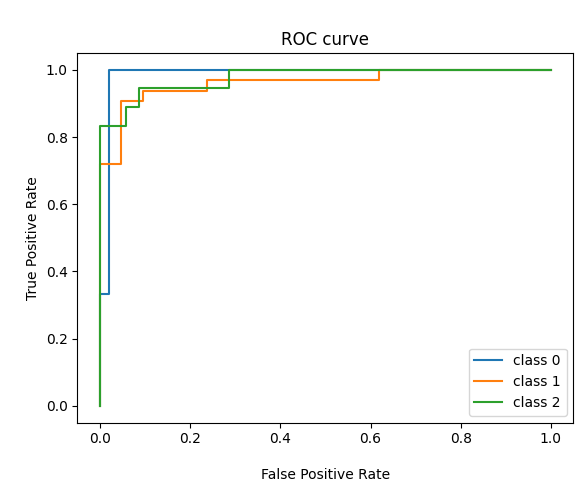


AUC:  {0: 0.9866666666666667, 1: 0.9613095238095238, 2: 0.9761904761904762}


In [ ]:
accuracy, cm, cr, _ = make_eval_reports(full_model, train_data, test_data, 20, eval_opt="test")

### 2. Model for Facial hair vs no facial hair

use SMOTE to oversample

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 72)        26208     
                                                                 
 batch_normalization_16 (Ba  (None, 72, 72, 72)        288       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 72, 72, 72)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 35, 35, 72)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 35, 35, 144)       5081

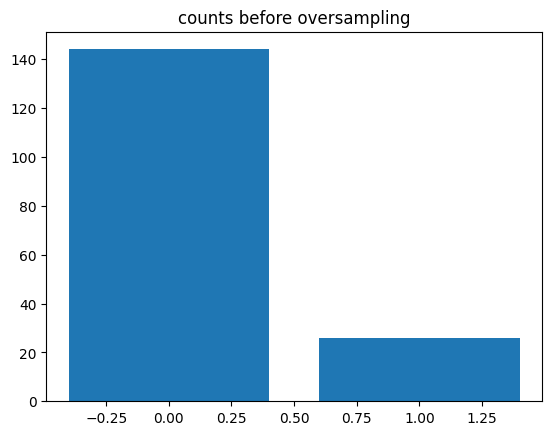

class 0: n = 144
class 1: n = 144


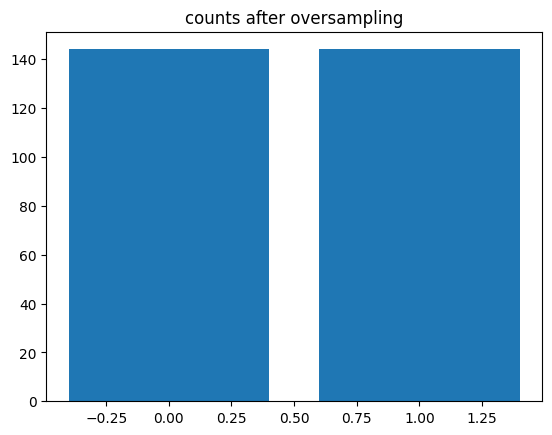

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 4200)              37804200  
                                                                 
 dropout_15 (Dropout)        (None, 4200)              0         
                                                                 
 dense_46 (Dense)            (None, 1500)              6301500   
                                                                 
 dropout_16 (Dropout)        (None, 1500)              0         
                                                                 
 dense_47 (Dense)            (None, 600)               900600    
                                                                 
 dropout_17 (Dropout)        (None, 600)               0         
                                                                 
 dense_48 (Dense)            (None, 250)              

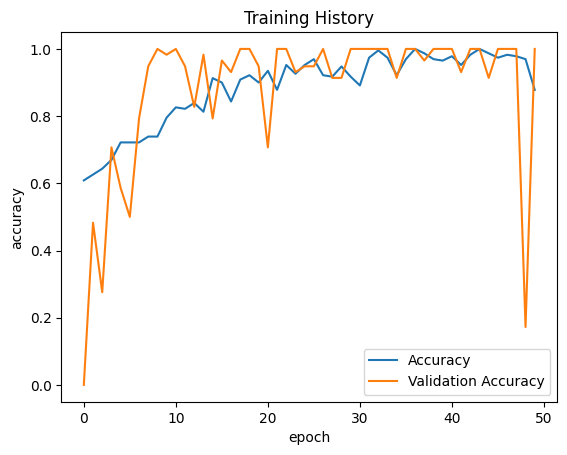

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_4 (Functional)        (None, 9000)              2015568   
                                                                 
 sequential_5 (Sequential)   (None, 2)                 45187906  
                                                                 
Total params: 47203474 (180.07 MB)
Trainable params: 47201890 (180.06 MB)
Non-trainable params: 1584 (6.19 KB)
_________________________________________________________________
9/9 [==============================] - 12s 1s/step
predicted labels: 
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]

 test data labels:
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

 test data accuracy score: 0.96

 confusion

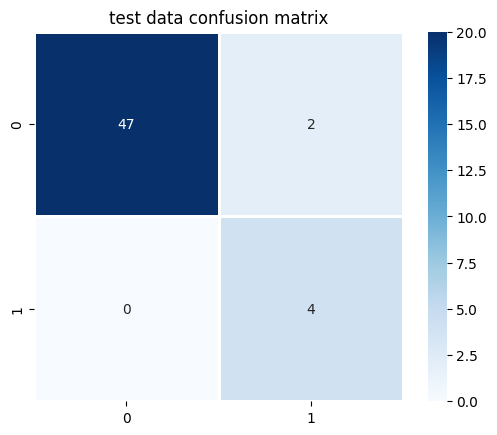

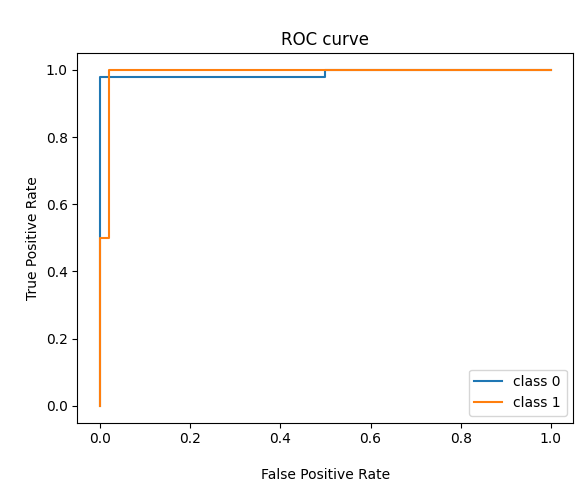


AUC:  {0: 0.9897959183673469, 1: 0.9897959183673469}


In [ ]:
# parameters
target_size = (224, 224)
epoch = 50
batch_size = 6
n_class = 2
y_name = "Facial Hair"
c_mode = "categorical"

# load model
MansooNet = load_model("MansooNet.h5")

# extract layers up to flatten
upto_flatten = Model(inputs=MansooNet.input, outputs=MansooNet.get_layer("flatten_1").output)
upto_flatten.summary()


# generate image data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# generate data
train_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=c_mode,
    shuffle=False,
    subset="training"
)

val_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=c_mode,
    shuffle=False,
    subset="validation"
)

# separate generator for test dataset
test_datagen = ImageDataGenerator(rescale=1./255.)

test_data = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=c_mode,
    shuffle=False
)

# extract z code
z_code_train = upto_flatten.predict(train_data)
z_code_test = upto_flatten.predict(test_data)


# plot class labels
plot_label_counts(train_data.labels, "before")

# SMOTE
oversampled_x, oversampled_y, oversampled_y_cat = my_smote(z_code_train, train_data.labels, nn=3)

# visaulize result after smote
plot_label_counts(oversampled_y, "after")


# train the model
# create dense layers
new_dense = create_flatten2dense(n_class)
new_dense.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=["accuracy"])
new_dense.summary()

# fit
# record start time
start_time = time.time()
history = new_dense.fit(oversampled_x, oversampled_y_cat, epochs=epoch, batch_size=batch_size, verbose=True, validation_split=0.2)
# record endtime
end_time = time.time()

print(f"\nTraining with Epochs={epoch}, Batch Size={batch_size}")
training_time = (end_time - start_time)/60
print(f'Model Training + Validation Time: {training_time:.2f} minutes')

# plot history
plot_history(history)

# print eval report
# piece the model together and print eval report
full_model = Sequential([upto_flatten, new_dense])
full_model.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=["accuracy"])
full_model.summary()
accuracy, cm, cr, _ = make_eval_reports(full_model, train_data, test_data, 20, eval_opt="test")

## 3. Glasses vs No Glasses

SMOTE

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 72)        26208     
                                                                 
 batch_normalization_16 (Ba  (None, 72, 72, 72)        288       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 72, 72, 72)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 35, 35, 72)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 35, 35, 144)       5081

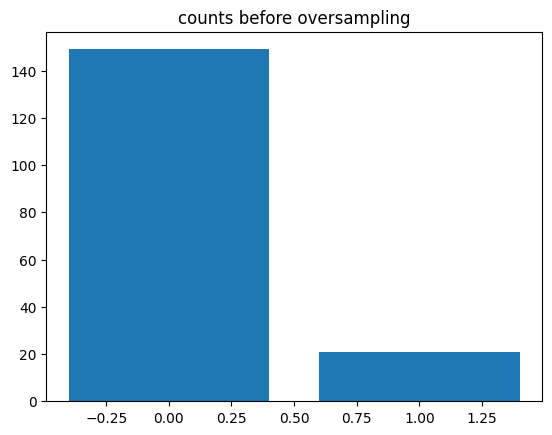

class 0: n = 149
class 1: n = 149


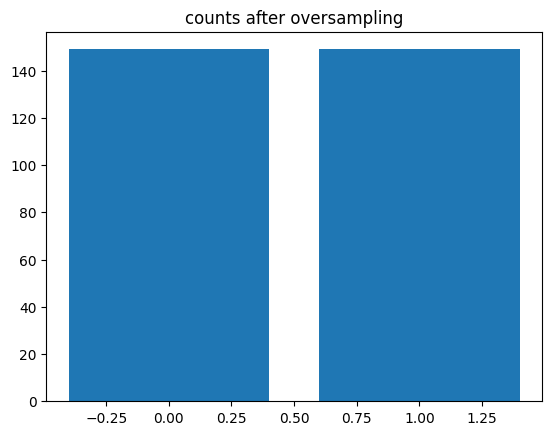

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 4200)              37804200  
                                                                 
 dropout_18 (Dropout)        (None, 4200)              0         
                                                                 
 dense_55 (Dense)            (None, 1500)              6301500   
                                                                 
 dropout_19 (Dropout)        (None, 1500)              0         
                                                                 
 dense_56 (Dense)            (None, 600)               900600    
                                                                 
 dropout_20 (Dropout)        (None, 600)               0         
                                                                 
 dense_57 (Dense)            (None, 250)              

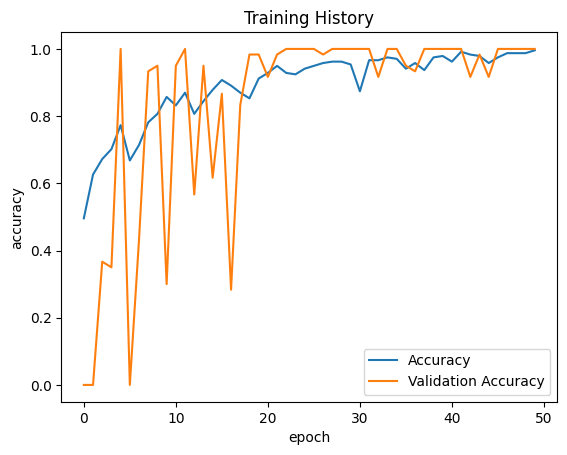

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_5 (Functional)        (None, 9000)              2015568   
                                                                 
 sequential_7 (Sequential)   (None, 2)                 45187906  
                                                                 
Total params: 47203474 (180.07 MB)
Trainable params: 47201890 (180.06 MB)
Non-trainable params: 1584 (6.19 KB)
_________________________________________________________________
9/9 [==============================] - 16s 2s/step
predicted labels: 
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]

 test data labels:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]

 test data accuracy score: 0.89

 confusion

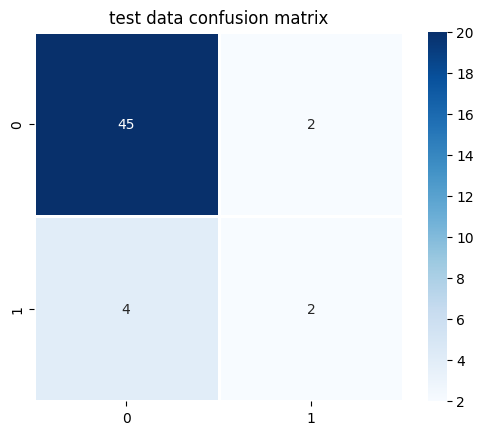

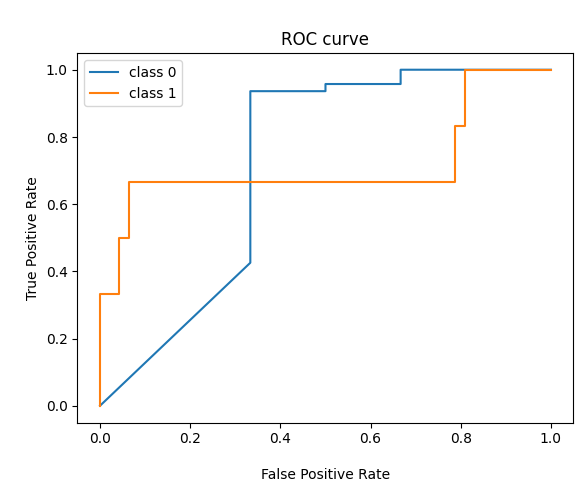


AUC:  {0: 0.7198581560283688, 1: 0.7163120567375887}


In [ ]:
# parameters
target_size = (224, 224)
epoch = 50
batch_size = 6
n_class = 2
y_name = "Glasses"
c_mode = "categorical"

# load model
MansooNet = load_model("MansooNet.h5")

# extract layers up to flatten
upto_flatten = Model(inputs=MansooNet.input, outputs=MansooNet.get_layer("flatten_1").output)
upto_flatten.summary()


# generate image data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# generate data
train_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=c_mode,
    shuffle=False,
    subset="training"
)

val_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=c_mode,
    shuffle=False,
    subset="validation"
)

# separate generator for test dataset
test_datagen = ImageDataGenerator(rescale=1./255.)

test_data = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=c_mode,
    shuffle=False
)

# extract z code
z_code_train = upto_flatten.predict(train_data)
z_code_test = upto_flatten.predict(test_data)


# plot class labels
plot_label_counts(train_data.labels, "before")

# SMOTE
oversampled_x, oversampled_y, oversampled_y_cat = my_smote(z_code_train, train_data.labels, nn=3)

# visaulize result after smote
plot_label_counts(oversampled_y, "after")


# train the model
# create dense layers
new_dense = create_flatten2dense(n_class)
new_dense.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=["accuracy"])
new_dense.summary()

# fit
# record start time
start_time = time.time()
history = new_dense.fit(oversampled_x, oversampled_y_cat, epochs=epoch, batch_size=batch_size, verbose=True, validation_split=0.2)
# record endtime
end_time = time.time()

print(f"\nTraining with Epochs={epoch}, Batch Size={batch_size}")
training_time = (end_time - start_time)/60
print(f'Model Training + Validation Time: {training_time:.2f} minutes')

# plot history
plot_history(history)

# print eval report
# piece the model together and print eval report
full_model = Sequential([upto_flatten, new_dense])
full_model.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=["accuracy"])
full_model.summary()
accuracy, cm, cr, _ = make_eval_reports(full_model, train_data, test_data, 20, eval_opt="test")

## 3. Hat vs no hat

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 72)        26208     
                                                                 
 batch_normalization_16 (Ba  (None, 72, 72, 72)        288       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 72, 72, 72)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 35, 35, 72)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 35, 35, 144)       5081

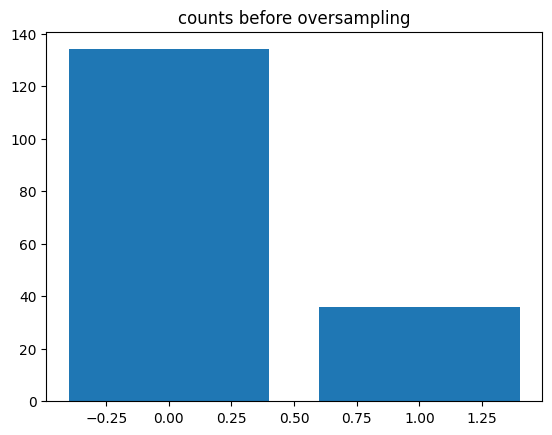

class 0: n = 134
class 1: n = 134


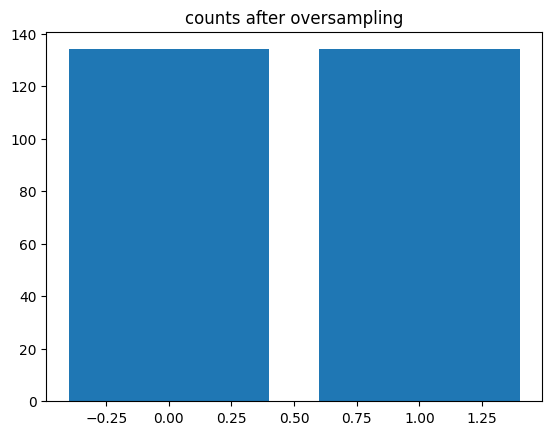

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 4200)              37804200  
                                                                 
 dropout_21 (Dropout)        (None, 4200)              0         
                                                                 
 dense_64 (Dense)            (None, 1500)              6301500   
                                                                 
 dropout_22 (Dropout)        (None, 1500)              0         
                                                                 
 dense_65 (Dense)            (None, 600)               900600    
                                                                 
 dropout_23 (Dropout)        (None, 600)               0         
                                                                 
 dense_66 (Dense)            (None, 250)              

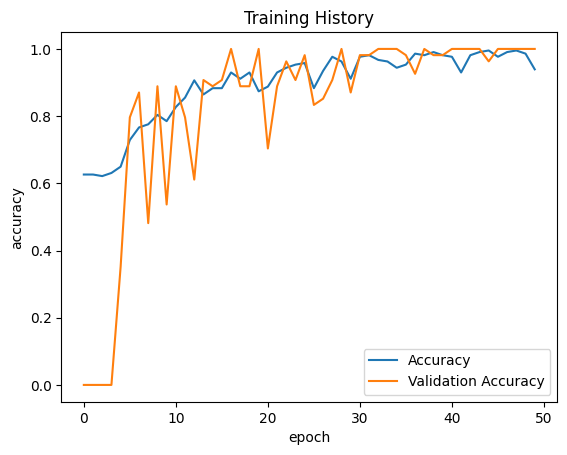

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_6 (Functional)        (None, 9000)              2015568   
                                                                 
 sequential_9 (Sequential)   (None, 2)                 45187906  
                                                                 
Total params: 47203474 (180.07 MB)
Trainable params: 47201890 (180.06 MB)
Non-trainable params: 1584 (6.19 KB)
_________________________________________________________________
9/9 [==============================] - 14s 2s/step
predicted labels: 
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0
 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0]

 test data labels:
 [1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0]

 test data accuracy score: 0.85

 confusio

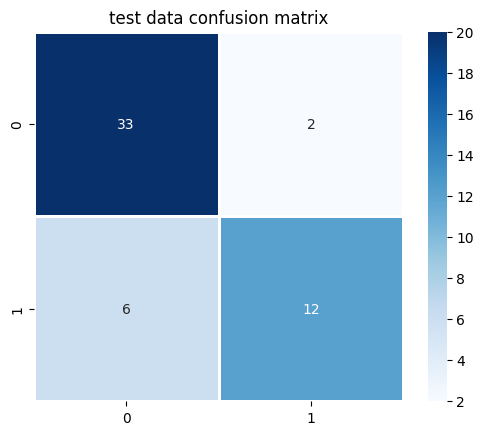

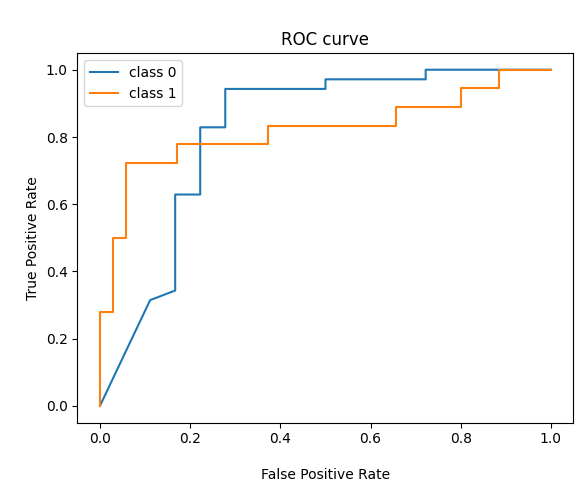


AUC:  {0: 0.8198412698412698, 1: 0.8206349206349206}


In [ ]:
# parameters
target_size = (224, 224)
epoch = 50
batch_size = 6
n_class = 2
y_name = "Hat"
c_mode = "categorical"

# load model
MansooNet = load_model("MansooNet.h5")

# extract layers up to flatten
upto_flatten = Model(inputs=MansooNet.input, outputs=MansooNet.get_layer("flatten_1").output)
upto_flatten.summary()


# generate image data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# generate data
train_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=c_mode,
    shuffle=False,
    subset="training"
)

val_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=c_mode,
    shuffle=False,
    subset="validation"
)

# separate generator for test dataset
test_datagen = ImageDataGenerator(rescale=1./255.)

test_data = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=c_mode,
    shuffle=False
)

# extract z code
z_code_train = upto_flatten.predict(train_data)
z_code_test = upto_flatten.predict(test_data)


# plot class labels
plot_label_counts(train_data.labels, "before")

# SMOTE
oversampled_x, oversampled_y, oversampled_y_cat = my_smote(z_code_train, train_data.labels, nn=3)

# visaulize result after smote
plot_label_counts(oversampled_y, "after")


# train the model
# create dense layers
new_dense = create_flatten2dense(n_class)
new_dense.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=["accuracy"])
new_dense.summary()

# fit
# record start time
start_time = time.time()
history = new_dense.fit(oversampled_x, oversampled_y_cat, epochs=epoch, batch_size=batch_size, verbose=True, validation_split=0.2)
# record endtime
end_time = time.time()

print(f"\nTraining with Epochs={epoch}, Batch Size={batch_size}")
training_time = (end_time - start_time)/60
print(f'Model Training + Validation Time: {training_time:.2f} minutes')

# plot history
plot_history(history)

# print eval report
# piece the model together and print eval report
full_model = Sequential([upto_flatten, new_dense])
full_model.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=["accuracy"])
full_model.summary()
accuracy, cm, cr, _ = make_eval_reports(full_model, train_data, test_data, 20, eval_opt="test")

## 4. Item in hand

no SMOTE

Found 170 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 53 validated image filenames belonging to 2 classes.
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 72)        26208     
                                                                 
 batch_normalization_16 (Ba  (None, 72, 72, 72)        288       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 72, 72, 72)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 35, 35, 72)        0         
 ng2D)       

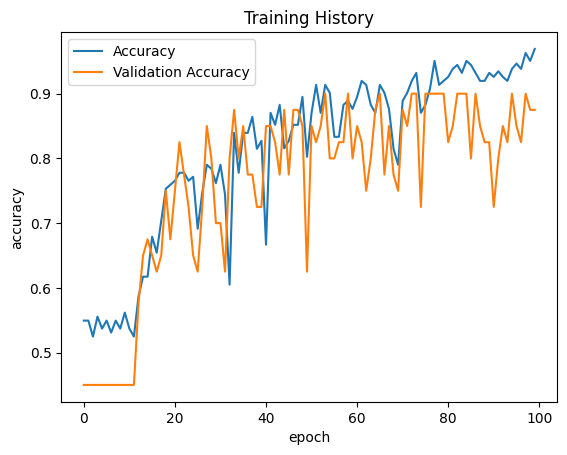

7/7 [==============================] - 11s 1s/step
predicted labels: 
 [0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1
 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1]

 test data labels:
 [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1]

 test data accuracy score: 0.75

 confusion matrix: 
 [[15  9]
 [ 4 25]]

 classification report               precision    recall  f1-score   support

           0       0.79      0.62      0.70        24
           1       0.74      0.86      0.79        29

    accuracy                           0.75        53
   macro avg       0.76      0.74      0.75        53
weighted avg       0.76      0.75      0.75        53



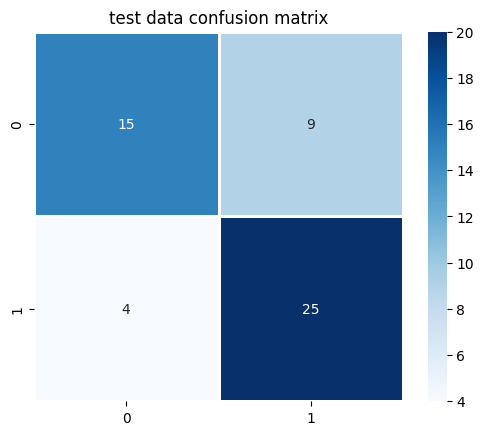

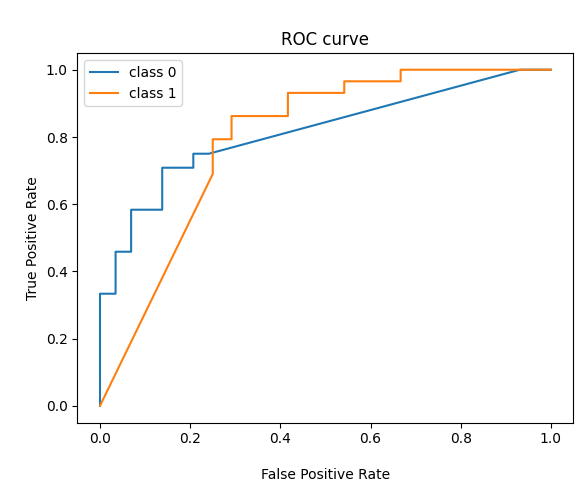


AUC:  {0: 0.8146551724137931, 1: 0.7974137931034483}


In [ ]:
# parameters
target_size = (224, 224)
epoch = 100
batch_size = 8
n_class = 2
y_name = "Item in hand"
c_mode = "categorical"

# generate image data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# generate data
train_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=c_mode,
    shuffle=False,
    subset="training"
)

val_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=c_mode,
    shuffle=False,
    subset="validation"
)

# separate generator for test dataset
test_datagen = ImageDataGenerator(rescale=1./255.)

test_data = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=c_mode,
    shuffle=False
)

# load model
MansooNet = load_model("MansooNet.h5")

# extract layers up to flatten
upto_flatten = Model(inputs=MansooNet.input, outputs=MansooNet.get_layer("flatten_1").output)
upto_flatten.summary()

# freeze the top
for i, layer in enumerate(upto_flatten.layers):
  layer.trainable = False
  print(i, layer.name, layer.trainable)


# train the model
# create dense layers
full_model = Sequential([upto_flatten])

# dense
full_model.add(Dense(units=4200, activation="relu", input_shape=(9000,)))
full_model.add(Dropout(0.4))
full_model.add(Dense(units=1500, activation="relu"))
full_model.add(Dropout(0.4))
full_model.add(Dense(units=600, activation="relu"))
full_model.add(Dropout(0.2))
full_model.add(Dense(units=250, activation="relu"))
full_model.add(Dense(units=100, activation="relu"))
full_model.add(Dense(units=50, activation="relu"))
full_model.add(Dense(units=20, activation="relu"))
full_model.add(Dense(units=8, activation="relu"))
full_model.add(Dense(units=n_class, activation="softmax"))

# compile
full_model.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=["accuracy"])
full_model.summary()


# fit
# record start time
train_num = train_data.samples
val_num = val_data.samples

start_time = time.time()
history = full_model.fit(x=train_data, epochs=epoch,
                        steps_per_epoch=train_num // batch_size,
                        validation_data=val_data,
                        validation_steps=val_num // batch_size,
                        verbose=True)
# record endtime
end_time = time.time()

print(f"\nTraining with Epochs={epoch}, Batch Size={batch_size}")
training_time = (end_time - start_time)/60
print(f'Model Training + Validation Time: {training_time:.2f} minutes')

# plot history
plot_history(history)

# print eval report
accuracy, cm, cr, _ = make_eval_reports(full_model, train_data, test_data, 20, eval_opt="test")

5. Human vs no Humann

no SMOTE

Found 170 validated image filenames belonging to 2 classes.
Found 42 validated image filenames belonging to 2 classes.
Found 53 validated image filenames belonging to 2 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 72)        26208     
                                                                 
 batch_normalization_16 (Ba  (None, 72, 72, 72)        288       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 72, 72, 72)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 35, 35, 72)        0         
 ng2D)         

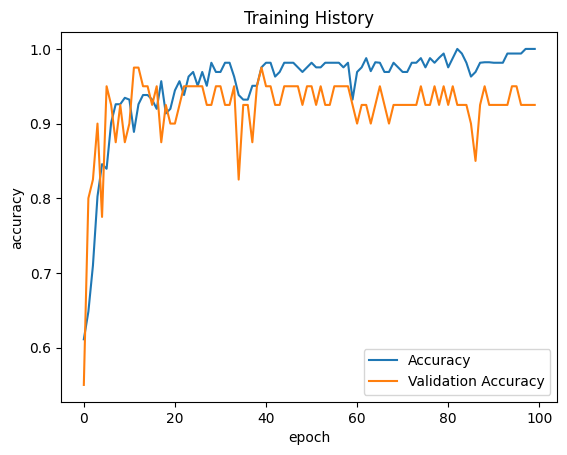

7/7 [==============================] - 11s 1s/step
predicted labels: 
 [0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1
 0 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1]

 test data labels:
 [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]

 test data accuracy score: 0.89

 confusion matrix: 
 [[20  3]
 [ 3 27]]

 classification report               precision    recall  f1-score   support

           0       0.87      0.87      0.87        23
           1       0.90      0.90      0.90        30

    accuracy                           0.89        53
   macro avg       0.88      0.88      0.88        53
weighted avg       0.89      0.89      0.89        53



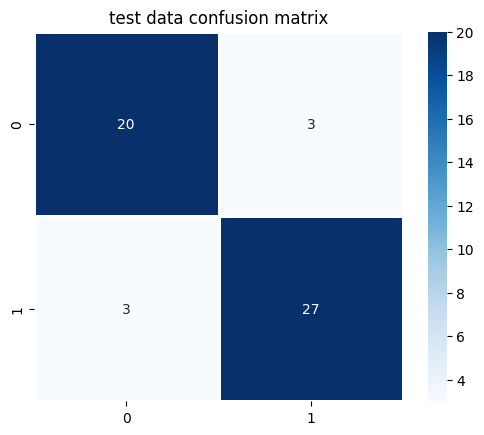

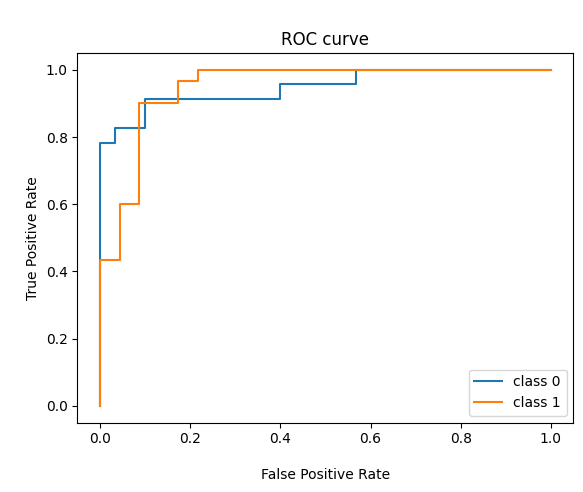


AUC:  {0: 0.9478260869565218, 1: 0.9478260869565218}


In [ ]:
# parameters
target_size = (224, 224)
epoch = 100
batch_size = 8
n_class = 2
y_name = "Human"
c_mode = "categorical"

# generate image data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# generate data
train_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=c_mode,
    shuffle=False,
    subset="training"
)

val_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=c_mode,
    shuffle=False,
    subset="validation"
)

# separate generator for test dataset
test_datagen = ImageDataGenerator(rescale=1./255.)

test_data = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=c_mode,
    shuffle=False
)

# load model
MansooNet = load_model("MansooNet.h5")

# extract layers up to flatten
upto_flatten = Model(inputs=MansooNet.input, outputs=MansooNet.get_layer("flatten_1").output)
upto_flatten.summary()

# freeze the top
for i, layer in enumerate(upto_flatten.layers):
  layer.trainable = False
  print(i, layer.name, layer.trainable)


# train the model
# create dense layers
full_model = Sequential([upto_flatten])

# dense
full_model.add(Dense(units=4200, activation="relu", input_shape=(9000,)))
full_model.add(Dropout(0.4))
full_model.add(Dense(units=1500, activation="relu"))
full_model.add(Dropout(0.4))
full_model.add(Dense(units=600, activation="relu"))
full_model.add(Dropout(0.2))
full_model.add(Dense(units=250, activation="relu"))
full_model.add(Dense(units=100, activation="relu"))
full_model.add(Dense(units=50, activation="relu"))
full_model.add(Dense(units=20, activation="relu"))
full_model.add(Dense(units=8, activation="relu"))
full_model.add(Dense(units=n_class, activation="softmax"))

# compile
full_model.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=["accuracy"])
full_model.summary()


# fit
# record start time
train_num = train_data.samples
val_num = val_data.samples

start_time = time.time()
history = full_model.fit(x=train_data, epochs=epoch,
                        steps_per_epoch=train_num // batch_size,
                        validation_data=val_data,
                        validation_steps=val_num // batch_size,
                        verbose=True)
# record endtime
end_time = time.time()

print(f"\nTraining with Epochs={epoch}, Batch Size={batch_size}")
training_time = (end_time - start_time)/60
print(f'Model Training + Validation Time: {training_time:.2f} minutes')

# plot history
plot_history(history)

# print eval report
accuracy, cm, cr, _ = make_eval_reports(full_model, train_data, test_data, 20, eval_opt="test")

### Veryfy that Gender model runs correctly when put together with `upto_flatten`.



When combined and re-trained the accuracy improved

<!-- No need to re-train the model `Sequential([upto_flatten, new_dense])` with the original training data because `new_dense` was already trained on the oversampled data and is capable of detecting the minority class.


If we re-train the combined model, we have to put in the original imbalanced data. Then the wegiths are going to be updated again based on the *imbalanced* data and the model will NOT detect the minority class. (as shown below) -->

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 72)        26208     
                                                                 
 batch_normalization_16 (Ba  (None, 72, 72, 72)        288       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 72, 72, 72)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 35, 35, 72)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 35, 35, 144)       5081

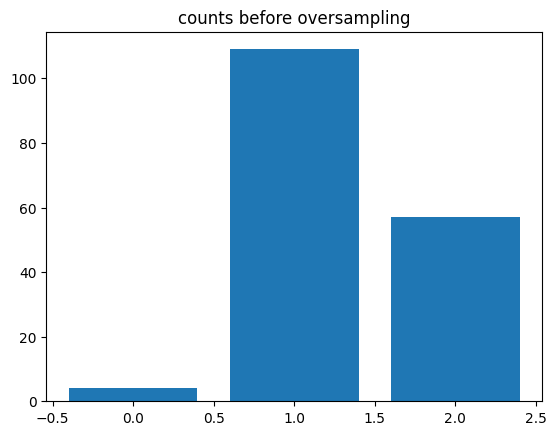

class 0: n = 109
class 1: n = 109
class 2: n = 109


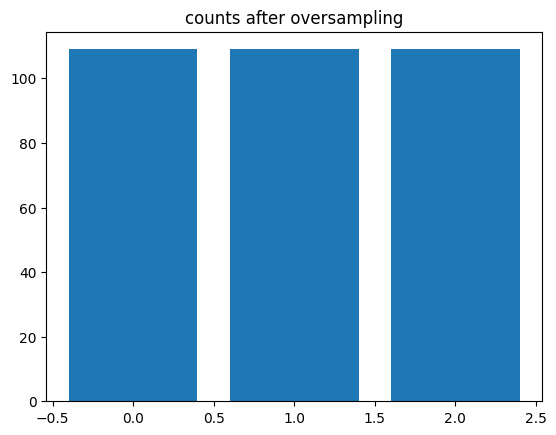

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 4200)              37804200  
                                                                 
 dropout_3 (Dropout)         (None, 4200)              0         
                                                                 
 dense_10 (Dense)            (None, 1500)              6301500   
                                                                 
 dropout_4 (Dropout)         (None, 1500)              0         
                                                                 
 dense_11 (Dense)            (None, 600)               900600    
                                                                 
 dropout_5 (Dropout)         (None, 600)               0         
                                                                 
 dense_12 (Dense)            (None, 250)              

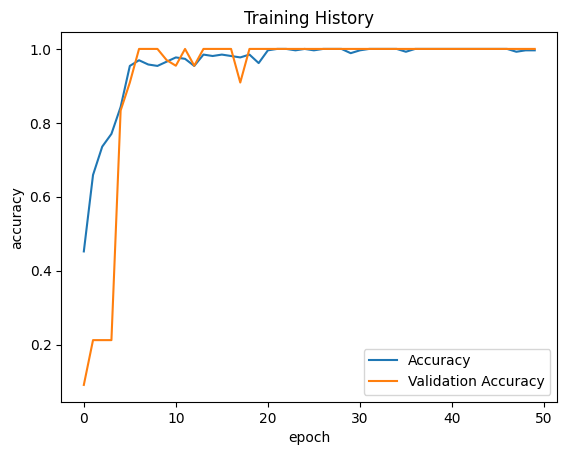

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 9000)              2015568   
                                                                 
 sequential_2 (Sequential)   (None, 3)                 45187915  
                                                                 
Total params: 47203483 (180.07 MB)
Trainable params: 47201899 (180.06 MB)
Non-trainable params: 1584 (6.19 KB)
_________________________________________________________________
metrics before fitting the full model again
7/7 [==============================] - 11s 2s/step
predicted labels: 
 [2 1 2 2 2 1 2 1 1 2 1 2 1 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 0 0 2 1 2 2 1 0 2 1 2 1 1 1 1]

 test data labels:
 [2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1]


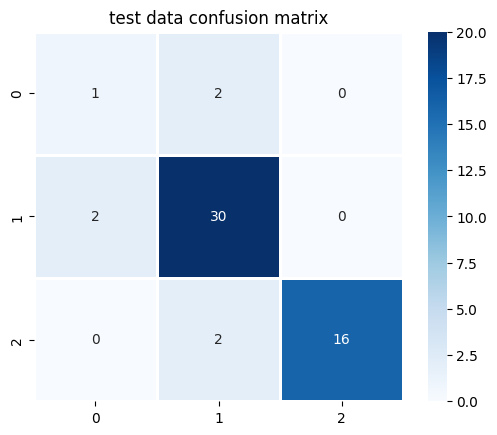

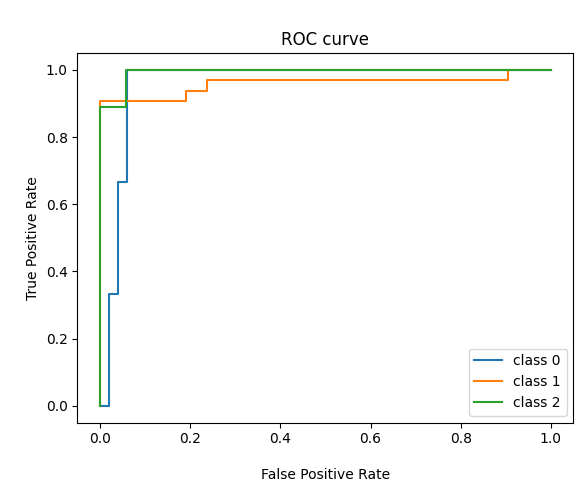


AUC:  {0: 0.96, 1: 0.9583333333333334, 2: 0.9936507936507937}
Epoch 1/50
21/21 [==============================] - 68s 3s/step - loss: 1.0381 - accuracy: 0.7963 - val_loss: 0.5544 - val_accuracy: 0.7000
Epoch 2/50
21/21 [==============================] - 60s 3s/step - loss: 0.3545 - accuracy: 0.8765 - val_loss: 0.3977 - val_accuracy: 0.8750
Epoch 3/50
21/21 [==============================] - 63s 3s/step - loss: 0.0960 - accuracy: 0.9753 - val_loss: 0.4017 - val_accuracy: 0.9000
Epoch 4/50
21/21 [==============================] - 63s 3s/step - loss: 0.0699 - accuracy: 0.9815 - val_loss: 0.2900 - val_accuracy: 0.9500
Epoch 5/50
21/21 [==============================] - 62s 3s/step - loss: 0.0320 - accuracy: 0.9938 - val_loss: 0.1865 - val_accuracy: 0.9500
Epoch 6/50
21/21 [==============================] - 71s 3s/step - loss: 0.0159 - accuracy: 0.9938 - val_loss: 0.2733 - val_accuracy: 0.9500
Epoch 7/50
21/21 [==============================] - 59s 3s/step - loss: 0.0038 - accuracy: 1.0000

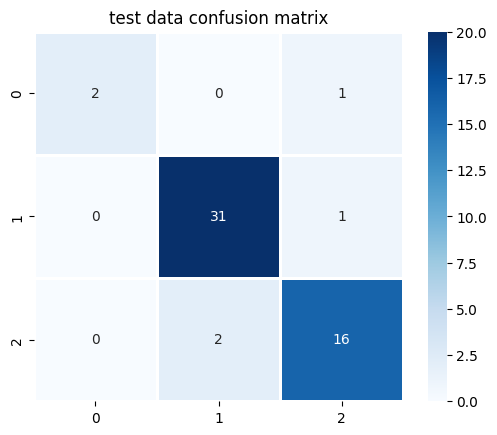

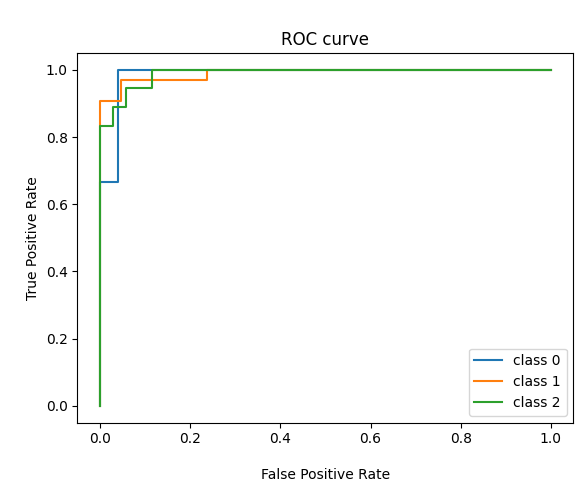


AUC:  {0: 0.9866666666666666, 1: 0.9895833333333333, 2: 0.9888888888888888}


In [ ]:
# parameters
target_size = (224, 224)
epoch = 50
batch_size = 8
n_class = 3
y_name = "Gender"

# load model
MansooNet = load_model("MansooNet.h5")

# extract layers up to flatten
upto_flatten = Model(inputs=MansooNet.input, outputs=MansooNet.get_layer("flatten_1").output)
upto_flatten.summary()


# generate image data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# generate data
train_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    subset="training"
)

val_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
)

# separate generator for test dataset
test_datagen = ImageDataGenerator(rescale=1./255.)

test_data = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Image Path",
    y_col=y_name,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# extract z code
z_code_train = upto_flatten.predict(train_data)
z_code_test = upto_flatten.predict(test_data)


# plot class labels
plot_label_counts(train_data.labels, "before")

# SMOTE
oversampled_x, oversampled_y, oversampled_y_cat = my_smote(z_code_train, train_data.labels, nn=3)

# visaulize result after smote
plot_label_counts(oversampled_y, "after")


# train the model
# create dense layers
new_dense = create_flatten2dense(n_class)
new_dense.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=["accuracy"])
new_dense.summary()

# fit
# record start time
start_time = time.time()
history = new_dense.fit(oversampled_x, oversampled_y_cat, epochs=epoch, batch_size=batch_size, verbose=True, validation_split=0.2)
# record endtime
end_time = time.time()

print(f"\nTraining with Epochs={epoch}, Batch Size={batch_size}")
training_time = (end_time - start_time)/60
print(f'Model Training + Validation Time: {training_time:.2f} minutes')

# plot history
plot_history(history)

# piece the model together and print eval report
full_model = Sequential([upto_flatten, new_dense])
full_model.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=["accuracy"])
full_model.summary()

print("metrics before fitting the full model again")
accuracy, cm, cr, _ = make_eval_reports(full_model, train_data, test_data, 20, eval_opt="test")


# try training the full model? - isn't this going to update the weights based on the imbalaced training data though?
# so no need to re-train the model (i.e. no need for `fit`), just have the model as is
# i.e. Sequential([upto_flatten, new_dense]) and we don't need further training.
train_num = train_data.samples
val_num = val_data.samples
full_model.fit(train_data, epochs=epoch,
               steps_per_epoch = train_num // batch_size,
               validation_data = val_data,
               validation_steps = val_num // batch_size,
               verbose=True)

# print eval report
print("metrics after fitting the full model again")
accuracy, cm, cr, _ = make_eval_reports(full_model, train_data, test_data, 20, eval_opt="test")